# Galaxy fitting with KinMS_fitter

This tutorial aims at getting you up and running with simple galaxy kinematic modelling using KinMS! 

To start you will need to install KinMS, and the KinMS_fitter routines. These can be installed together using `pip install kinms-fitter`.

To get started with kinematic modelling we will complete the following steps:
1. Generate a model to fit (can be skipped if you have your own observed data cube)
2. Read that cube in with KinMS_fitter, and provide some initial guesses for parameters.
3. Get fitting!



## Generate a model

Here we will use one of the KinMS test suite routines to generate a simple mock datacube that we can use to test our fitting. 


The `expdisk` function from the test suite creates a disc with an exponential surface brightness profile, and  a rotation curve that has a linear rise in the centre, and then is flat. This disc is observed with a 4$^{\prime\prime}$ beam, and has an extent and inclination that can be set by the user. See the other KinMS tutorials, and the test suite itself for full details.

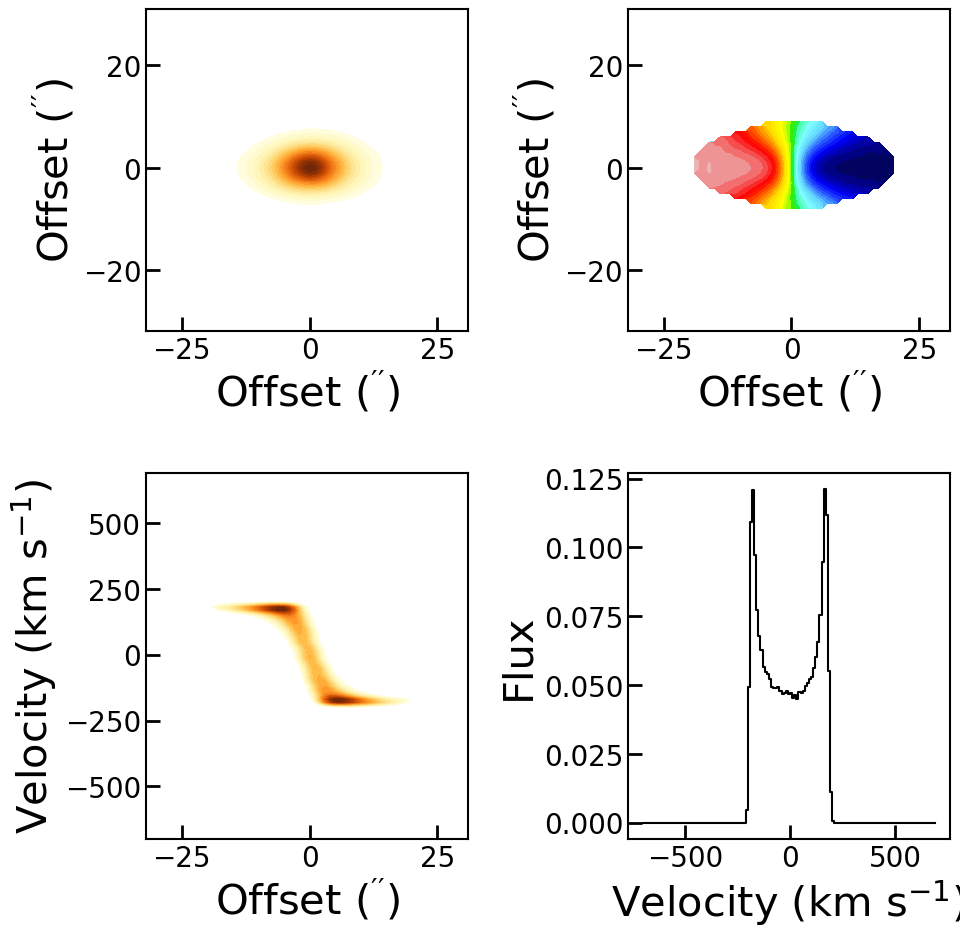

In [1]:
from kinms import KinMS
from kinms.examples.KinMS_testsuite import expdisk

data=expdisk(fileName='Output',scalerad=5, inc=60)

This has now created the mock datacube, named 'Output_simcube.fits' in our directory. We then add some noise (correlated with the inteferometer beam), to make the test realistic so we can proceed with `KinMS_fitter`.

In [2]:
from astropy.io import fits
from astropy.convolution import convolve
import numpy as np
def add_noise(cube,error):
    hdul=fits.open(cube)
    beamSize=[hdul[0].header['BMAJ']*3600.,hdul[0].header['BMIN']*3600.,hdul[0].header['BPA']]
    cellSize=np.abs(hdul[0].header['CDELT1']*3600.)
    psf=KinMS.makebeam(1,hdul[0].header['NAXIS1'], hdul[0].header['NAXIS2'], beamSize,cellSize=cellSize)
    noise=np.random.normal(size=hdul[0].data.shape)
    for i in range(noise.shape[0]):
        noise[i, :, :] = convolve(noise[i, :, :], psf)
    noise=noise*(error/np.nanstd(noise))
    mycube=hdul[0].data+noise
    fits.writeto(cube,mycube,hdul[0].header,overwrite=True)
    
add_noise('Output_simcube.fits',1e-3)

## Fitting with KinMS_fitter

### Philosophy of KinMS_fitter

KinMS_fitter has been designed to be as simple as possible. If run with all parameters at their defaults it will:

* Assume the gas surface brightness profile has an exponential form
* Assume you want to fit the velocity curve freely in individual beam-sized apertures (tilted-ring style)
* Fit the free parameters of the above, along with the geometric paramters of the disc (PA, inclination), and the typical nuisance paramters (kinematic centre in RA, Dec, Vsys; and the total flux of the system)

By using other parameters one can in a simple way:

* Use parameterized rotation curves (e.g. arctan models, Kelpalrians, disc/bulge, etc) or rotation curves from MGE models, AND combinations of these.
* Use more complex surface brightness parameterisations (rings, holes, etc)  AND combinations of these.

First here will we demonstrate the simple case.


We begin by importing KinMS_fitter:

In [3]:
from kinms_fitter import kinms_fitter

Now we can load in the datacube.

In [4]:
fit=kinms_fitter('Output_simcube.fits')

As our datacube is a bit bigger than our actual source, for speed we may want to cut down the cube. Ideal sizes are $2^N$, but you can experiment with your own sources. KinMS_fitter will tell you how long a single model takes to generate, so you can optimise this. 

`spatial_trim` cuts your cube in the spatial directions, and needs to be a 4 element vector of the form [start_x, end_x, start_y, end_y]

`spectral_trim` shows what channels to include. Here our signal is between channel ~47 and 93. We want to ensure we have some line-free channels on either end, but not too many.

`linefree_chans` allows you to tell the code where to estimate the RMS - it defaults to channels 1 -> 6.

Given the above, the line below will be a better choice for our datacube than leaving everything at its defaults.

In [5]:
fit=kinms_fitter('Output_simcube.fits',spatial_trim=[16,48,16,48],spectral_trim=[43,98],linefree_chans=[30,45])

Now we can provide initial guesses for parameters, if we wish. The code attempts to set sensible defaults, but these are not perfect. Below we set guesses for the position angle only (see later for a full list of possibilities).

In [6]:
fit.pa_guess=90

Given we are using the simple "tilted-ring" type model for velocities, its also crucial to set the hyperparameter `nrings`. This is the number of beam size elements you have across your galaxy. Set this too large and it will do crazy things in the outer parts where it isnt constrained!

In [7]:
fit.nrings=5

Now we are ready to run a simple fit! We start with a simple least-square minimisation routine that relatively quickly can hopefully find a good fit. We can then use this best fit as an input to an MCMC approach which can give us good error estimates. 

*Note: Some problems are too challenging for the simple minimiser. In these cases I recommend skipping stright to the MCMC approach*

The code will show the initial guess model over the input data, (optionally) output a variety of fitting messages, and then finally plot the newly optimised model over the data. The time taken will vary depending how close to optimal your initial guesses are. This simple fit starting from a very non-optimal model took ~3.5 minutes on my desktop machine.

==============   Welcome to KinMS_fitter!   ==============

        ██╗  ██╗██╗███╗   ██╗███╗   ███╗███████╗
        ██║ ██╔╝██║████╗  ██║████╗ ████║██╔════╝
        █████╔╝ ██║██╔██╗ ██║██╔████╔██║███████╗
        ██╔═██╗ ██║██║╚██╗██║██║╚██╔╝██║╚════██║
        ██║  ██╗██║██║ ╚████║██║ ╚═╝ ██║███████║
        ╚═╝  ╚═╝╚═╝╚═╝  ╚═══╝╚═╝     ╚═╝╚══════╝
        
One model evaluation takes 0.16 seconds


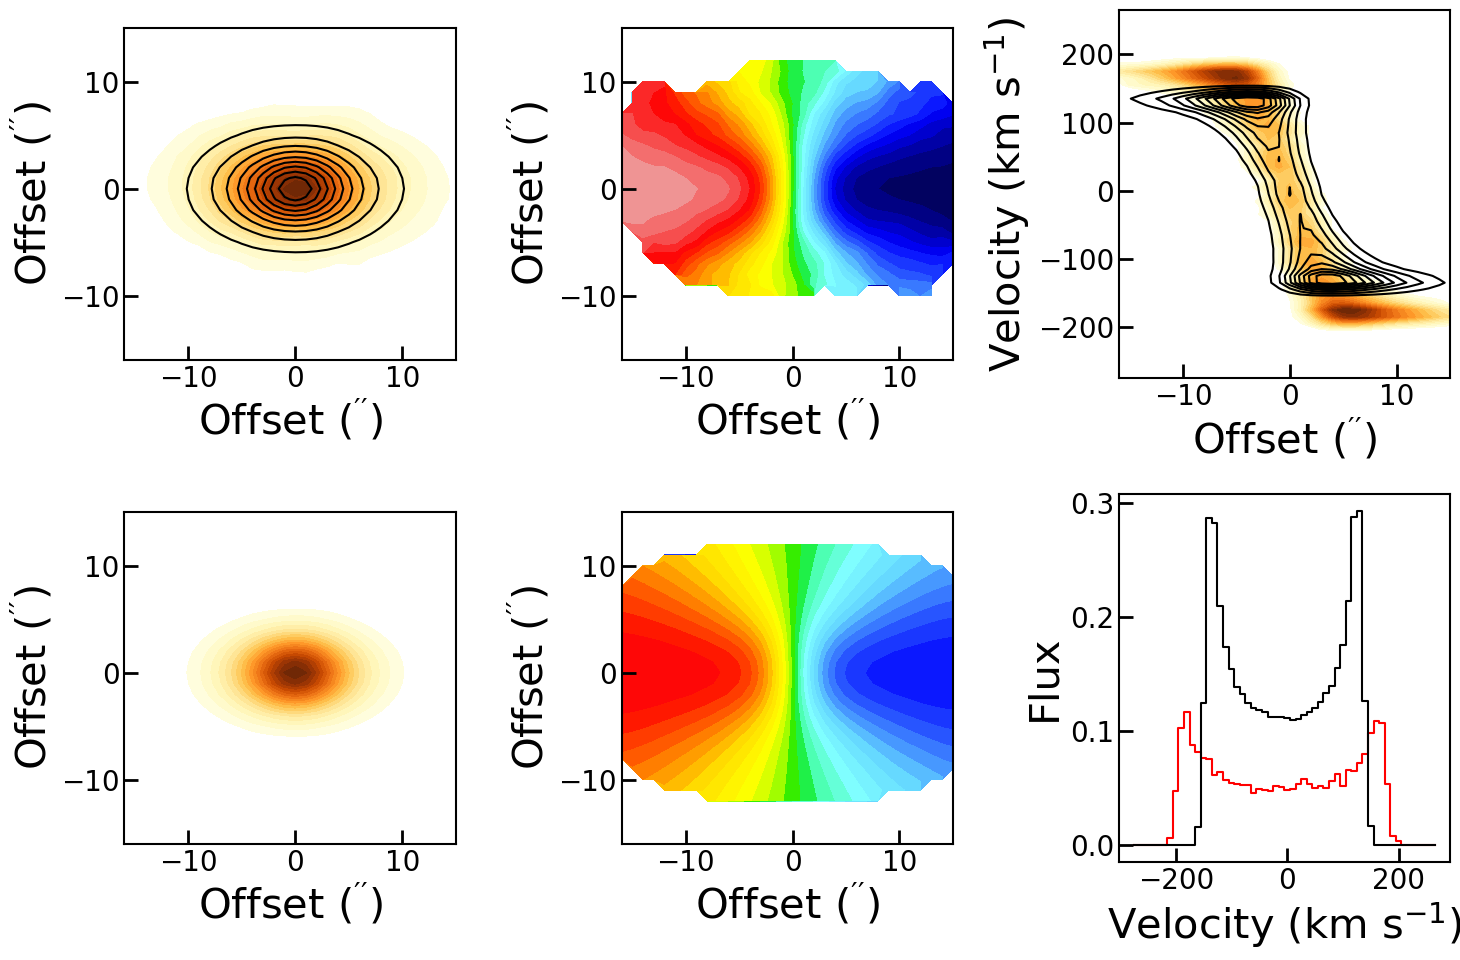

============== Begin simple fitting process ==============
Steps: 0 chi2: 13489.150311139458
Steps: 50 chi2: 13451.054410307157
Steps: 100 chi2: 2133.2605806814563
Steps: 150 chi2: 2045.9438745050568
Steps: 200 chi2: 2243.5981216038213
Steps: 250 chi2: 1871.670954833793
Steps: 300 chi2: 1292.1471048267558
Steps: 350 chi2: 1290.9418303736556
Steps: 400 chi2: 1185.1497235620839
Steps: 450 chi2: 1184.2468474756627
Steps: 500 chi2: 849.8133130596091
Steps: 550 chi2: 780.0539457413818
Steps: 600 chi2: 3387.8007730470504
Steps: 650 chi2: 643.8808246140542
Steps: 700 chi2: 621.9376672303848
Steps: 750 chi2: 616.6400224349508
Steps: 800 chi2: 605.9064836901505
Steps: 850 chi2: 585.0222422430601
Steps: 900 chi2: 570.2682014155091
Steps: 950 chi2: 569.927915105195
Steps: 1000 chi2: 569.9494318122703
Steps: 1050 chi2: 565.1856256277881
Steps: 1100 chi2: 555.519880483612
Steps: 1150 chi2: 546.368274751794
Optimization terminated successfully.
         Current function value: 544.130756
         It

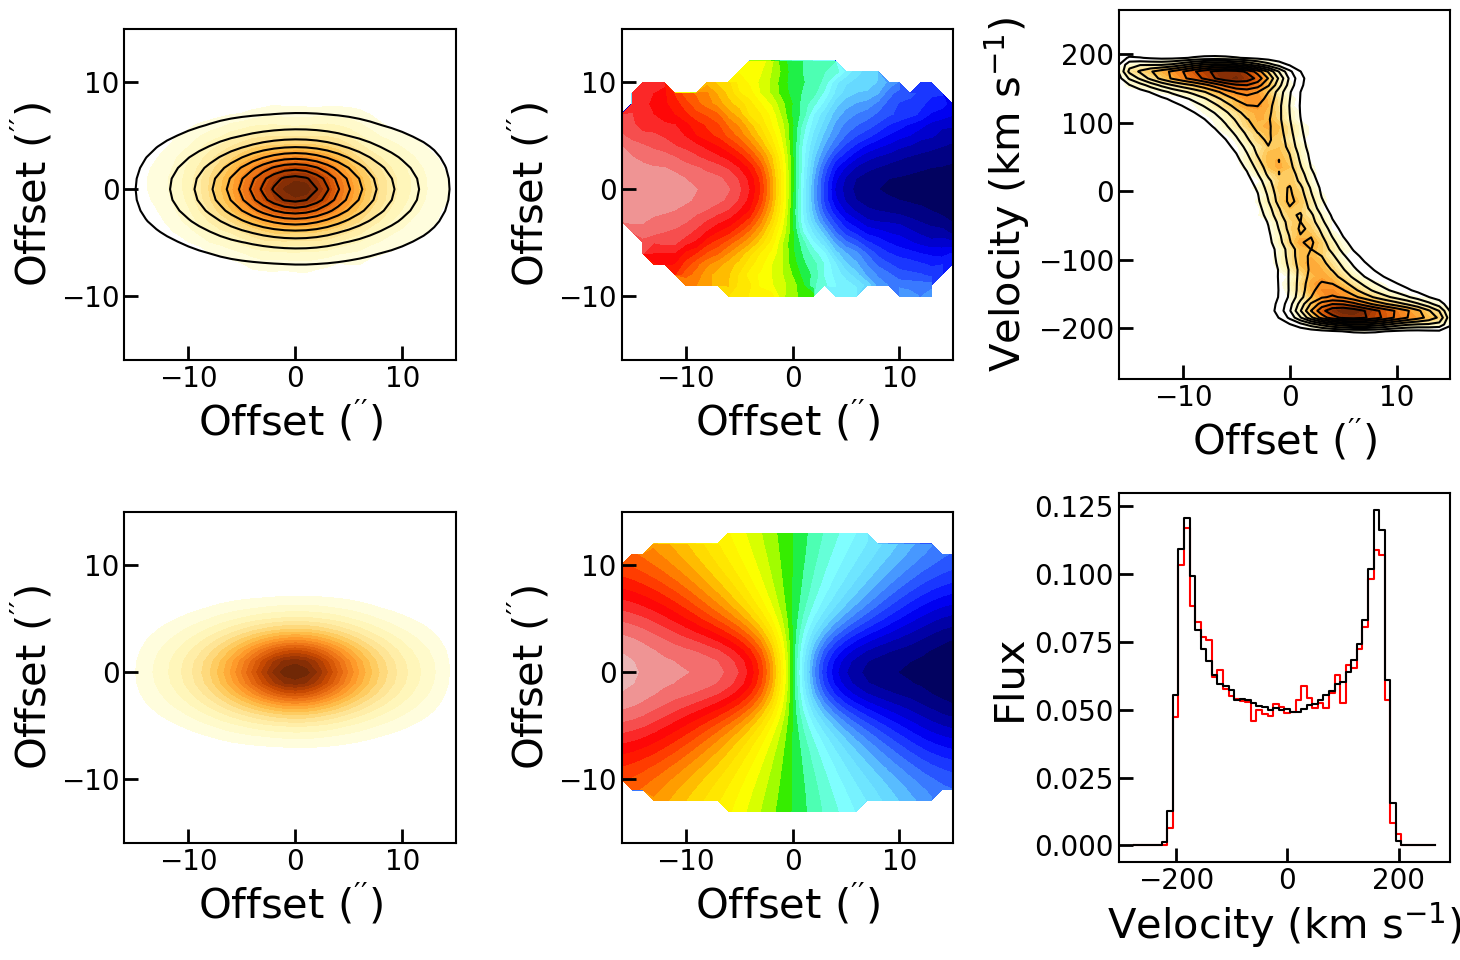

In [8]:
bestvals, besterrs, acceptedsteps, acceptedsteps_ll, parsfixed=fit.run(method='simple')

In [9]:
from astropy.table import Table
truths=[12,10,0,25,10,90,60,5,  100., 210., 210., 210., 210.] # the true values we would hope to retrieve
print(Table([fit.labels,bestvals,truths],names=('Quantity', 'Bestfit', 'True value')))

 Quantity        Bestfit       True value
---------- ------------------- ----------
        Xc  12.000012099474327       12.0
        Yc    10.0000097084472       10.0
      Vsys 0.09963733405095854        0.0
   totflux  26.213097220231173       25.0
   veldisp   9.768494473239192       10.0
        PA   90.01593441953591       90.0
       inc   65.95955972059667       60.0
Rscale_exp   5.359591816886508        5.0
        V0  194.29933342811012      100.0
        V1   197.7801493447028      210.0
        V2  202.59345218721492      210.0
        V3  194.73275832578702      210.0
        V4  212.40440496929384      210.0


As you can see we get a very nice fit, with the parameters all pretty much correct. 

*Note: The model displayed in the plots is noiseless, hence the velocity field show is often more extended than that of the real data, because it is not clipped in the same way. That is totally normal, and not an indication of errors.*

Now one can go ahead and run a longer chain, and plot the corner plots to visualize covariances etc. With `method='mcmc'` you want to run for a good number of steps - e.g. `fit.niters=10000` or `30000`, to get good estimates of the errors and visualise the covariances. This is relatively slow - but the code is parallelised, so will more quickly on a larger machine. You can control the number of threads the code uses by setting `fit.nprocesses` to a positive integer. 

Here we are starting the fit from scratch again. You can avoid this and use the simple mode fit as the input to the MCMC by setting `method='both'` - see below for an example.

Once the run has finished (this takes ~twenty minutes on my machine - if you need results faster try running on a large machine with many cores) you can plot the corner plot to see the covariances etc by setting `fit.show_corner=True`. If you'd like to save these plots then set `fit.pdf=True`.

==============   Welcome to KinMS_fitter!   ==============

        ██╗  ██╗██╗███╗   ██╗███╗   ███╗███████╗
        ██║ ██╔╝██║████╗  ██║████╗ ████║██╔════╝
        █████╔╝ ██║██╔██╗ ██║██╔████╔██║███████╗
        ██╔═██╗ ██║██║╚██╗██║██║╚██╔╝██║╚════██║
        ██║  ██╗██║██║ ╚████║██║ ╚═╝ ██║███████║
        ╚═╝  ╚═╝╚═╝╚═╝  ╚═══╝╚═╝     ╚═╝╚══════╝
        
One model evaluation takes 0.25 seconds


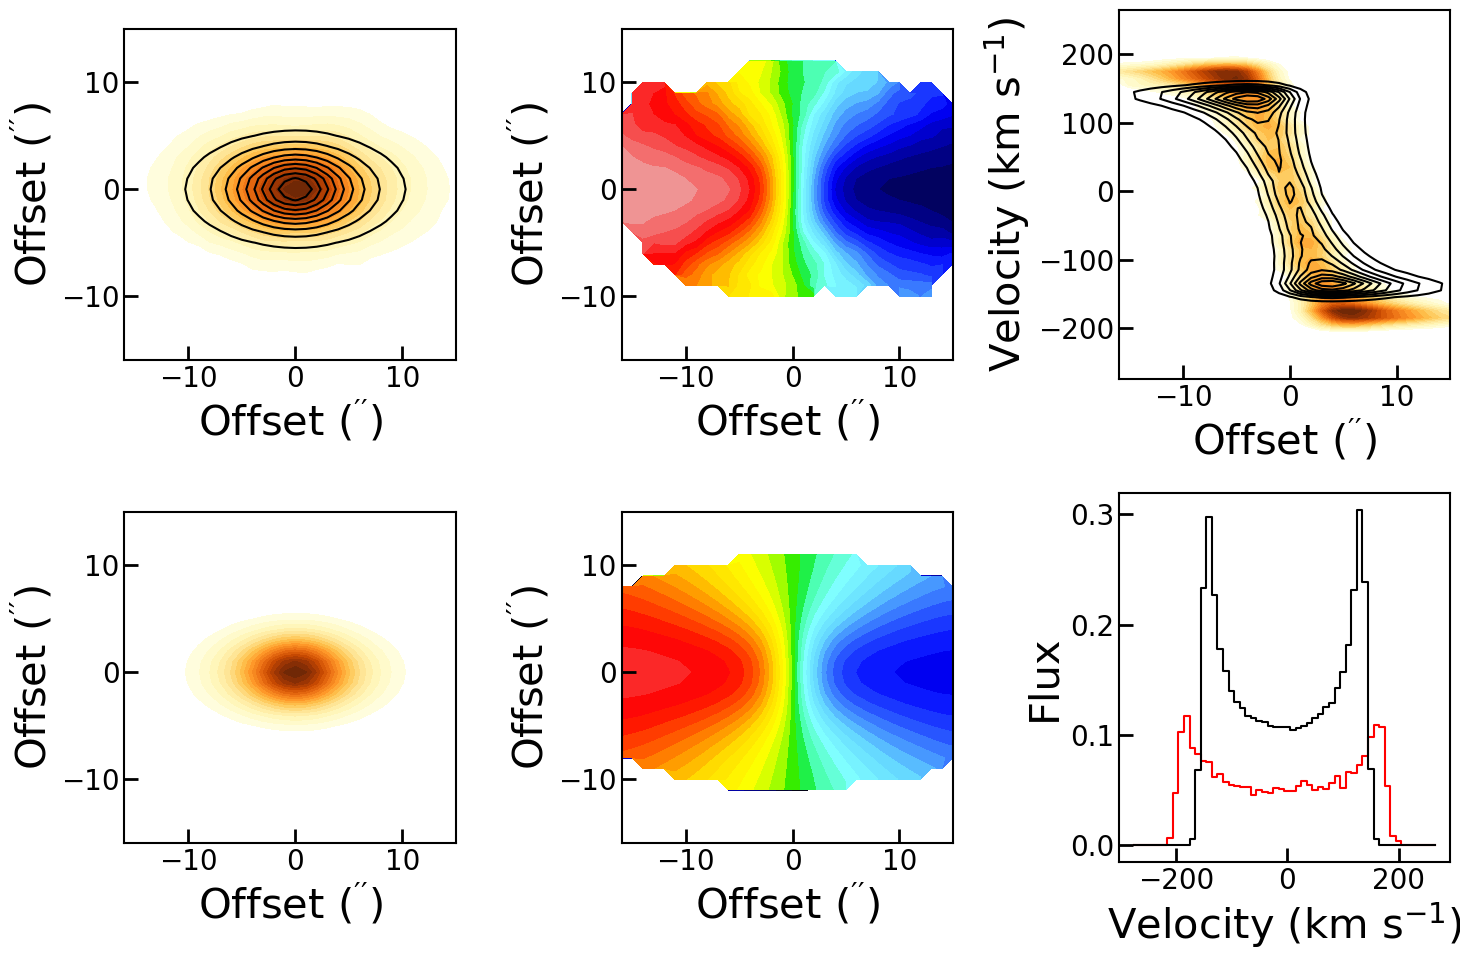

==============  Begin MCMC fitting process  ==============
Parameters Fixed: []
Correction for chi-sqr variance applied: 11.296752335894869
Non uniform priors used:  V0 V1 V2 V3 V4
Doing chain 1
     Chain 0 has not converged - Accept rate: 0.10923076923076923
     Chain 0 has not converged - Accept rate: 0.2169230769230769
     --> Still varying: ['V0']
Chain 0 converged: LL: -230.75392800891328 - Accept rate:0.42923076923076925
Best chain so far!
Best fit:
  Xc: -0.10965278781073969
  Yc: 0.06538303523504023
  Vsys: 0.2905056889052532
  totflux: 27.148879663105376
  veldisp: 9.366787822776127
  PA: 90.31770195620246
  inc: 60.19377662867974
  Rscale_exp: 4.952744854763944
  V0: 96.16999352824274
  V1: 215.76001116527297
  V2: 206.9518758193712
  V3: 211.63051197451142
  V4: 209.13923156155016
Starting final chain


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
100%|█████████▉| 29988/29995 [19:26<00:00, 25.70it/s]
[Parallel(n_jobs=7)]: Done   5 out of   7 | elapsed: 19.5min remaining:  7.8min
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed: 19.9min finished


Final best fit values and 1sigma errors:
  Xc: -0.03904186152548013 ± 0.06232989896998408
  Yc: 0.03639107956490456 ± 0.05677985089680359
  Vsys: 0.11101192137277305 ± 0.5600773395729085
  totflux: 26.906821070789967 + 0.6087442187509176 - 0.5087397852204134
  veldisp: 9.179281235040682 + 0.7618537522223878 - 0.6546122277930468
  PA: 90.12917613080293 ± 0.4481563134094131
  inc: 59.41364242942635 + 1.2277099776619949 - 0.9587171814723376
  Rscale_exp: 4.9315408795767395 + 0.14999584156119994 - 0.12294451331870704
  V0: 84.28182487078601 + 10.42974587809887 - 14.885690126815177
  V1: 219.2262440659771 + 3.4254678787857245 - 2.9324862665418436
  V2: 207.2321074291241 + 3.5800702618035416 - 3.137459964687139
  V3: 212.23551497630518 ± 3.4678448853791934
  V4: 209.07526688073324 ± 4.835518299049653
MCMC fitting process took 1514.16 seconds


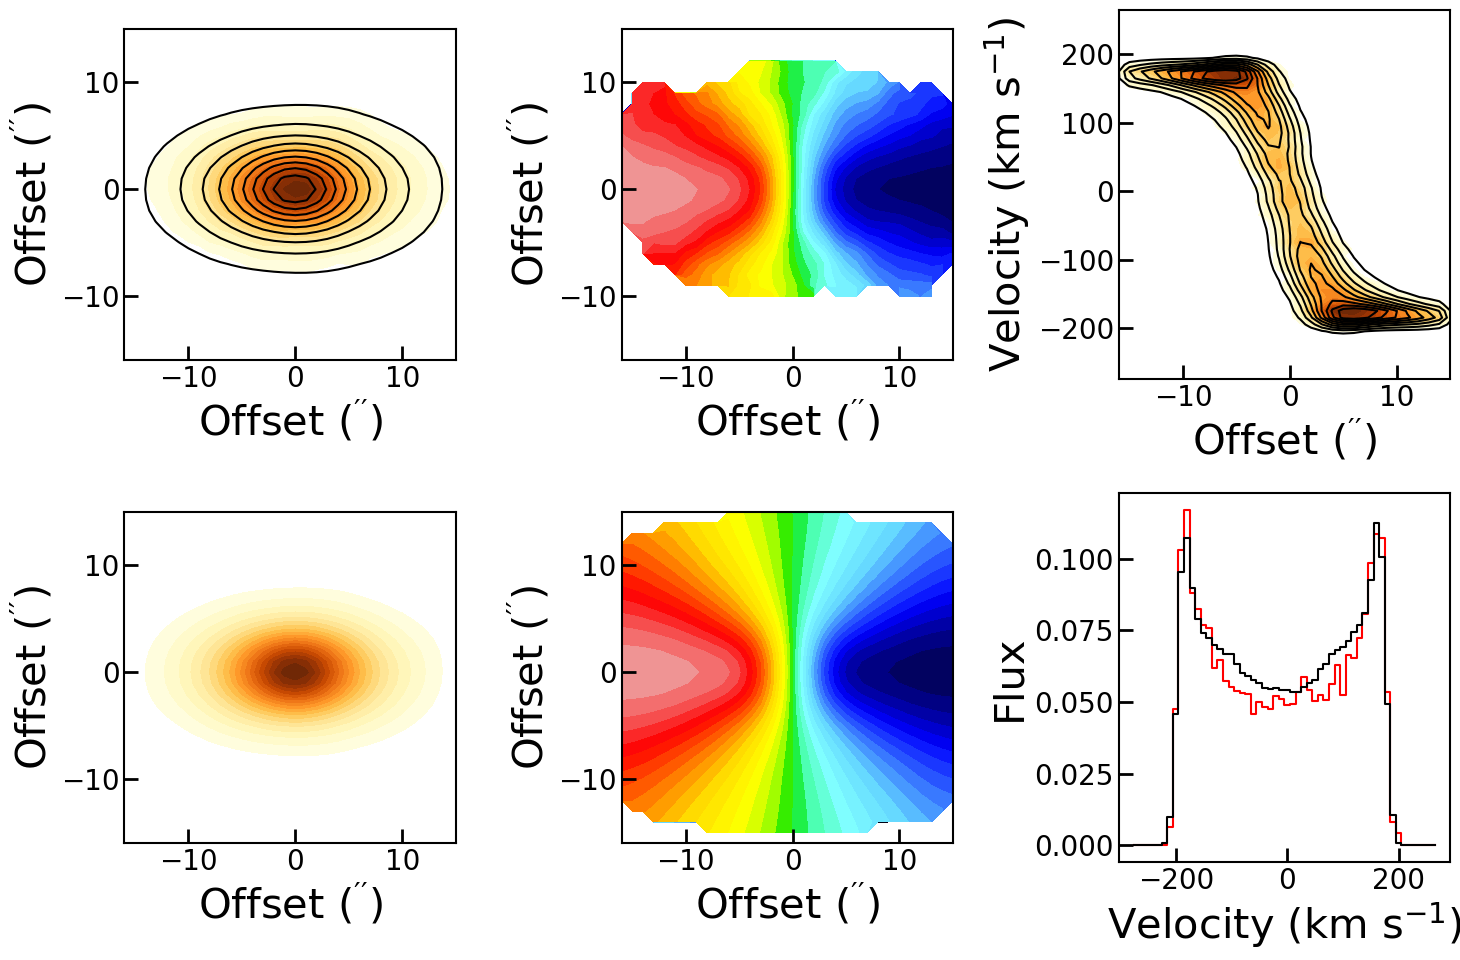

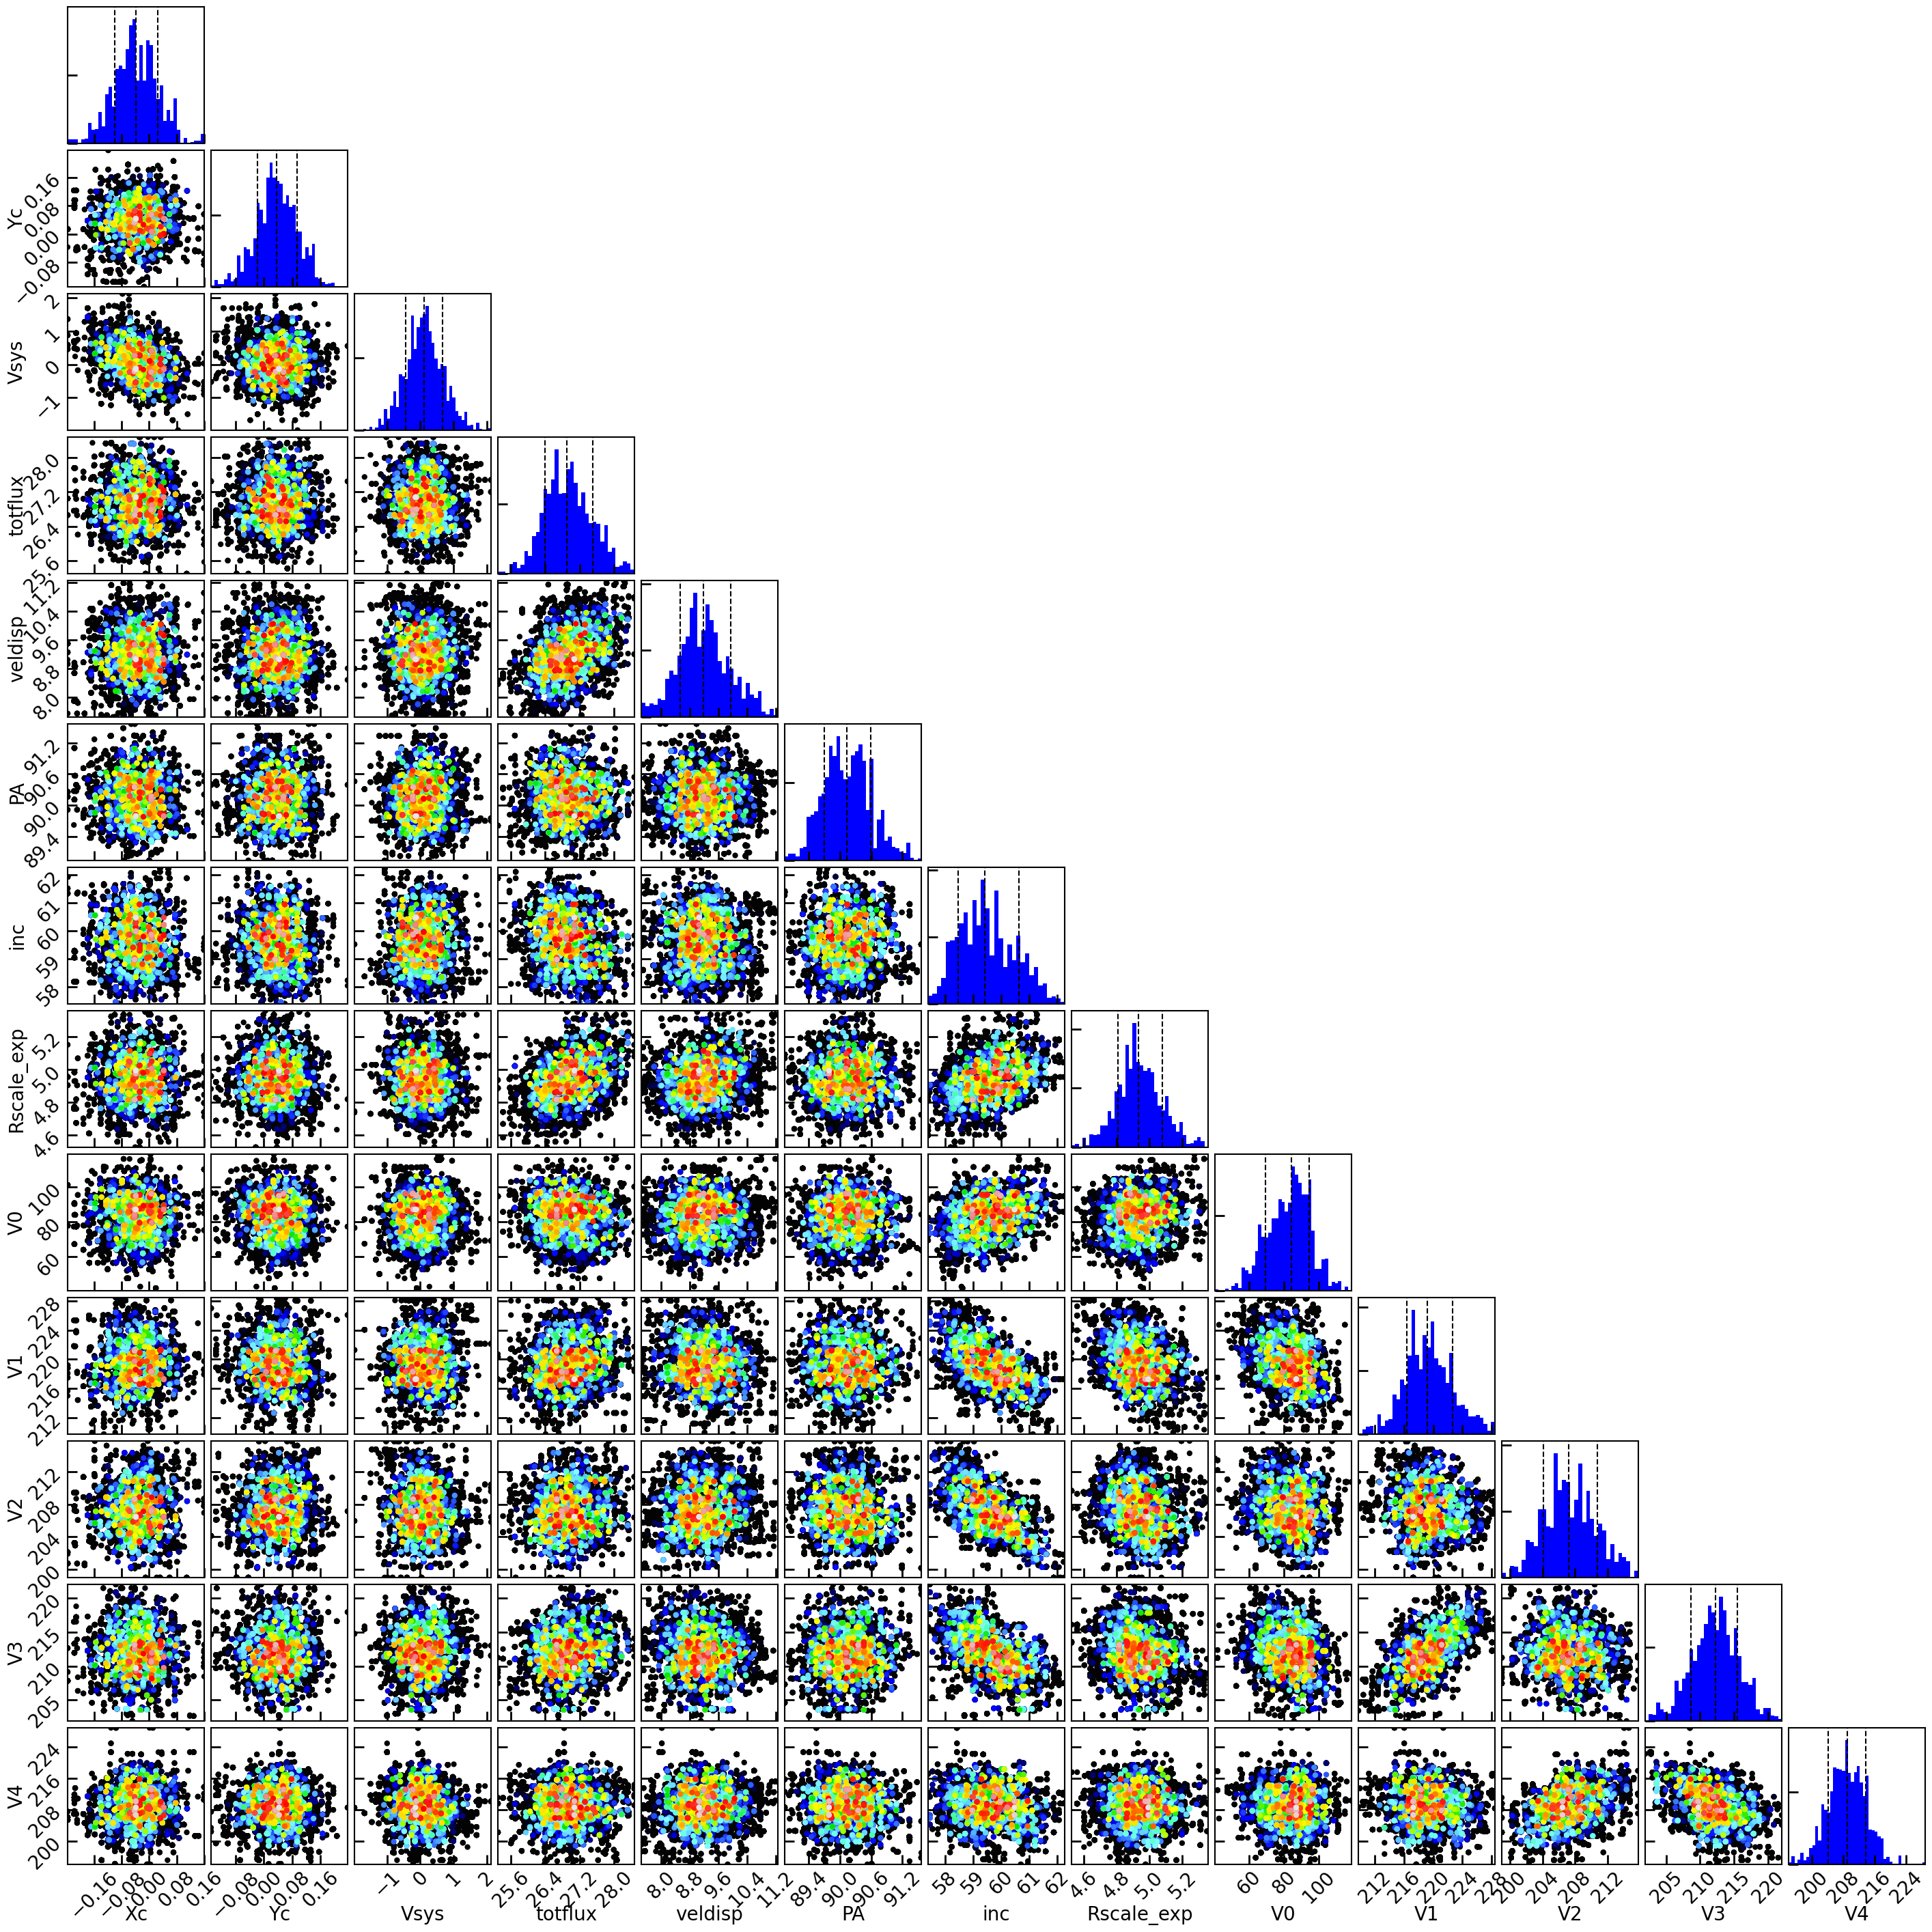

In [10]:
fit=kinms_fitter('Output_simcube.fits',spatial_trim=[16,48,16,48],spectral_trim=[43,98],linefree_chans=[30,45])
fit.pa_guess=90
fit.inc_guess=65.
fit.nrings=5
fit.niters=30000
fit.show_corner=True # show the corner plots
bestvals, besterrs, acceptedsteps, acceptedsteps_ll, parsfixed =fit.run(method='mcmc')   

## Using more complex velocity and surface brightness profile shapes

Often an exponential disc/tilted ring type velocity structure does not capture the physics you want to include in your modelling. In these cases KinMS_fitter has a simple way to help - via the `sb_profs` and `velocity_profs` modules.

In [11]:
from kinms_fitter.sb_profs import sb_profs
from kinms_fitter.velocity_profs import velocity_profs  

Examples of current functionality of these are shown below - adding new features is easy however, so get in contact if your favourite form is not avaliable!

### Surface brightness profiles

First, lets reproduce a basic exponential disc, as used by default in KinMS_fitter. You can call the `sb_profs.expdisk` profile, and supply guesses, and limits, for its two free parameters (the central brightness ($I_0$), and the scale radius ($r_{scale}$) as below. 


$
\begin{align}
\large I_{gas}(r) = I_0 e^{\frac{-r}{r_{scale}}}
\end{align}
$

If you are only passing a single function to KinMS_fitter then you should fix the flux normalisation, as that will be handled seperately by fitting the total flux of the model. You can do this by passing just the scale length parameter. If you supply multiple components then you should fix one, and fit the other fluxes relative to that. 

In [12]:
guesses=[10]
mymodel=[sb_profs.expdisk(guesses=guesses,minimums=[0],maximums=[20],fixed=[False])]

To demonstrate this profile, we can define a radius array, and plot the SB profile resulting:

Text(0, 0.5, 'Brightness')

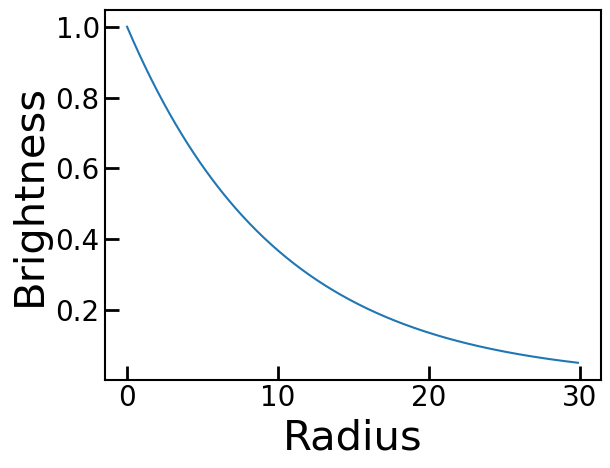

In [13]:
import matplotlib.pyplot as plt
import numpy as np
r=np.arange(0,30,0.1)
plt.plot(r,sb_profs.eval(mymodel,r,guesses)) 
plt.xlabel("Radius")
plt.ylabel("Brightness")

As you may have noted above, mymodel is actually a list. As such we can combine many surface profiles together by adding them to the list! Below we add a second, more concentrated exponential disc. Note we only fix one of the fluxes!

In [14]:
mymodel=[sb_profs.expdisk(guesses=[10],minimums=[0],maximums=[20]),\
         sb_profs.expdisk(guesses=[1,3],minimums=[0,0],maximums=[100,20],fixed=[False,False])]

Lets see what that looks like... (total result in blue, the two components are plotted as orange and green lines).

Text(0, 0.5, 'Brightness')

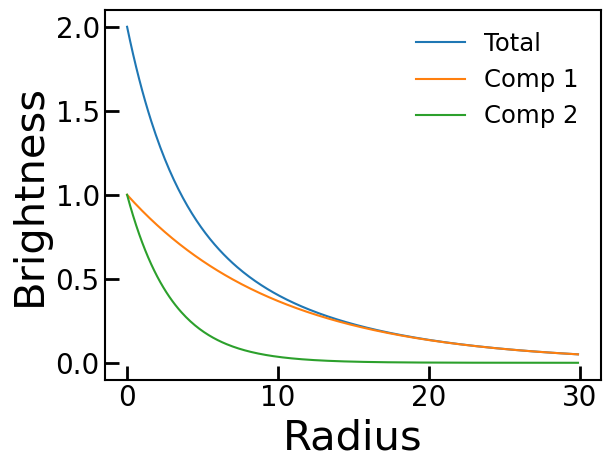

In [15]:
guesses=np.concatenate([i.guess for i in mymodel]) # this line just sets the parameters to the guesses inputed above
plt.plot(r,sb_profs.eval(mymodel,r,guesses),label='Total')
plt.plot(r,sb_profs.eval([mymodel[0]],r,guesses[0:1]),label='Comp 1')
plt.plot(r,sb_profs.eval([mymodel[1]],r,guesses[1:]),label='Comp 2')
plt.legend(frameon=False)
plt.xlabel("Radius")
plt.ylabel("Brightness")

Instead of an exponential, maybe we add in a gaussian ring! Here the free parameters are the gaussians peak, its central radius, and width. Note that the defaults assume none of the parameters are fixed, so you can leaved `fixed=...` out if you wish.

In [16]:
mymodel=[sb_profs.expdisk(guesses=[10],minimums=[0],maximums=[20]),\
         sb_profs.gaussian(guesses=[2,10,1],minimums=[0,0,0],maximums=[10,100,20])]

Text(0, 0.5, 'Brightness')

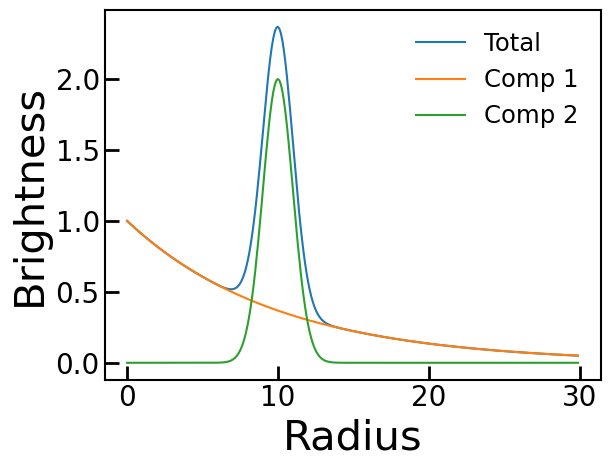

In [17]:
guesses=np.concatenate([i.guess for i in mymodel]) # this line just sets the parameters to the guesses inputed above
plt.plot(r,sb_profs.eval(mymodel,r,guesses),label='Total')
plt.plot(r,sb_profs.eval([mymodel[0]],r,guesses[0:1]),label='Comp 1')
plt.plot(r,sb_profs.eval([mymodel[1]],r,guesses[1:]),label='Comp 2')
plt.legend(frameon=False)
plt.xlabel("Radius")
plt.ylabel("Brightness")

Finally, you can add multiplicative components to the model, like a cutoff, to here to simulate a hole in the centre of a galaxy. The free parameters are radius of the start and end of the cutoff.

Text(0, 0.5, 'Brightness')

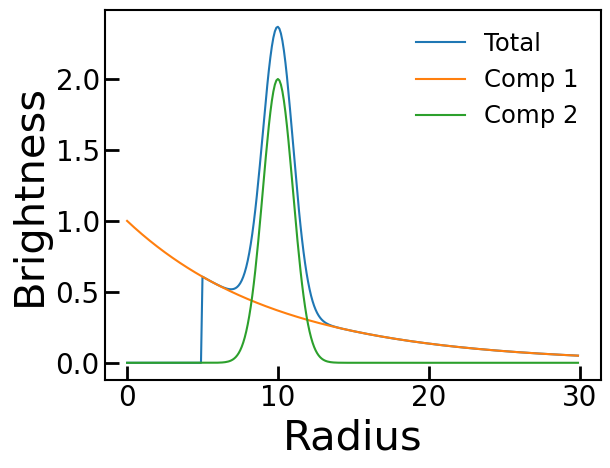

In [18]:
mymodel=[sb_profs.expdisk(guesses=[10],minimums=[0],maximums=[20]),\
         sb_profs.gaussian(guesses=[2,10,1],minimums=[0,0,0],maximums=[10,100,20]),\
         sb_profs.cutoff(guesses=[0,5],minimums=[0,1],maximums=[10,20])]

guesses=np.concatenate([i.guess for i in mymodel]) # this line just sets the parameters to the guesses inputed above
plt.plot(r,sb_profs.eval(mymodel,r,guesses),label='Total')
plt.plot(r,sb_profs.eval([mymodel[0]],r,guesses[0:1]),label='Comp 1')
plt.plot(r,sb_profs.eval([mymodel[1]],r,guesses[1:4]),label='Comp 2')
plt.legend(frameon=False)
plt.xlabel("Radius")
plt.ylabel("Brightness")

Note: you cant plot component 3 alone, as it is a multiplicative component, but its effect is clear in the blue "total" line.

In this way you can add surface brightness components together, and fit their free parameters with KinMS_fitter.

<b>Warning: pay careful attention to areas where you could create parameter degeneracies. For instance multiple flux components, or when you have two similar profiles (e.g. our double exponential, above) that could swap positions. You should fix parameters, or constain the minimums/maximums where needed to avoid this!</b>

### Velocity profiles

Adding different velocity profiles works similarly to adding surface brightness components, but using `kinms_fitter.velocity_profs`. At the moment four different types of velocity profiles exist in the module, but more will be added as time goes on. These are:

* A tilted ring (i.e. piecewise linear) velocity curve with an arbitary number of free parameters. This has one set of  hyperparameters - the radii of the rings to fit. Guesses (and limits) required for the velocity of each ring in km/s.<p>

* An arctan function $V(r)=\frac{2V_{max}}{\pi}arctan\frac{R}{R_{turn}}$. This profile has no hyperparameters, and requires guesses (and limits) for $V_{max}$ in km/s and $R_{turn}$ in arcseconds.<p>

* A Keplarian $V(r)=\sqrt{\frac{GM}{R}}$. This profile has the distance to the galaxy as a hyperparameter (to convert the radius in arcseconds to parsecs), and requires a single input guess (with limits) for M, in units of $\log_{10}$ solar masses. <p>
    
* An MGE potential (see https://www-astro.physics.ox.ac.uk/~mxc/software/#mge). Input hyperparameters are the MGE surface brightness, radius and axial ratio (q). Either one or two fitted parameters can either be supplied -  the M/L in the band the MGE was created in (in Msun/Lsun units), and (optionally) the black hole mass. The inclination of the stellar body of the galaxy is assumed to be the same as that of the gas disc.<p>
    
* An NFW dark matter halo. The only required input hyperparameter is the distance to the object in question, while the Hubble Parameter can also be specified (default=67 km/s/Mpc). Two parameters are fitted: The log of the halo mass (M$_200$) and the concentration.  <p>
    
* A sersic density profile, which is assumed to be round. The only input hyperparameter is the distance to the object in question, and the fitted parameters are the log of the stellar mass of that component, its effective radius, and its sersic index. <p>
    
When multiple velocity profiles are included in your model, the final result will have the profiles added in quadarature. Some examples are shown below:
    
Firstly, we can duplicate the tilted ring type approach set as the default:

In [19]:
bincentroids=np.arange(0,30,5) # radii of the bin centroids
mymodel = [velocity_profs.tilted_rings(bincentroids,guesses=[0,250,260,260,250,230],minimums=np.zeros(bincentroids.size),maximums=np.ones(bincentroids.size)*500.)]

And we can plot this, as before.

Text(0, 0.5, 'Velocity (km/s)')

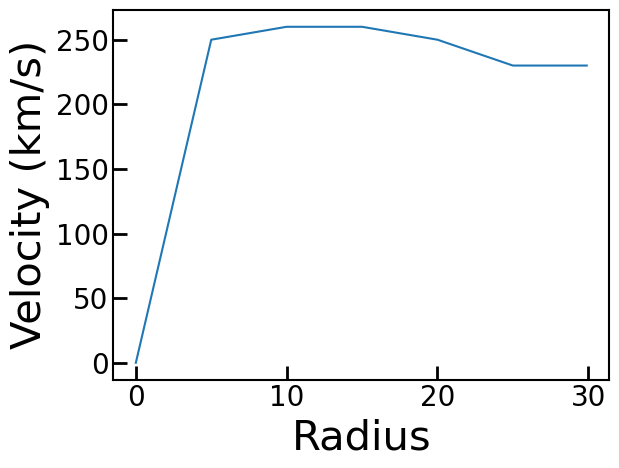

In [20]:
params=np.concatenate([i.guess for i in mymodel])
plt.plot(r,velocity_profs.eval(mymodel,r,params)) 
plt.xlabel("Radius")
plt.ylabel("Velocity (km/s)")

Now one could imagine adding a central point mass (e.g. a SMBH):

In [21]:
mymodel=[velocity_profs.tilted_rings(bincentroids,guesses=[0,250,260,260,250,230],minimums=np.zeros(bincentroids.size),maximums=np.zeros(bincentroids.size)),\
         velocity_profs.keplarian(distance=16.5,guesses=[8],minimums=[5],maximums=[10])]

Plotting this results in the following:

Text(0, 0.5, 'Velocity (km/s)')

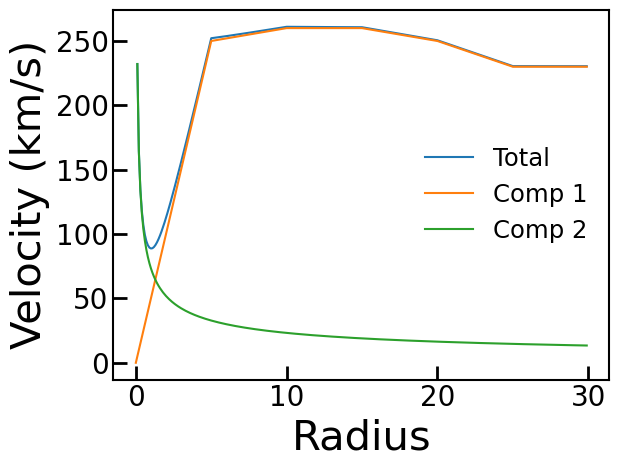

In [22]:
params=np.concatenate([i.guess for i in mymodel])
plt.plot(r,velocity_profs.eval(mymodel,r,params),label="Total")
plt.plot(r,velocity_profs.eval([mymodel[0]],r,params[0:-1]),label='Comp 1')
plt.plot(r,velocity_profs.eval([mymodel[1]],r,params[-1:]),label='Comp 2')
plt.legend(frameon=False)
plt.xlabel("Radius")
plt.ylabel("Velocity (km/s)")

One could replace the tilted rings with an arctangent as so:

Text(0, 0.5, 'Velocity (km/s)')

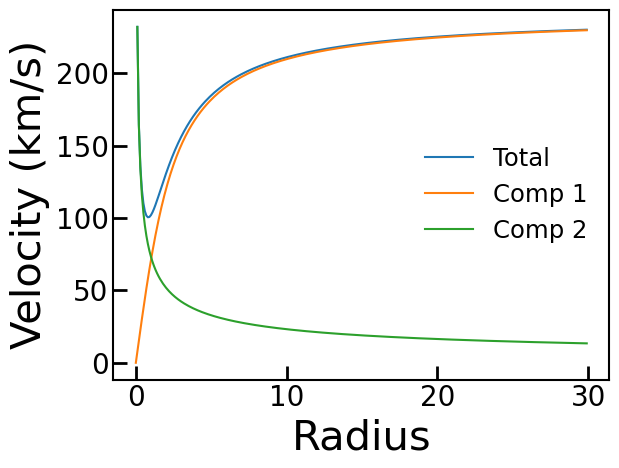

In [23]:
mymodel=[velocity_profs.arctan(guesses=[240,2],minimums=[0,0],maximums=[500,20]),\
         velocity_profs.keplarian(distance=16.5,guesses=[8],minimums=[5],maximums=[10])]

params=np.concatenate([i.guess for i in mymodel])
plt.plot(r,velocity_profs.eval(mymodel,r,params),label="Total")
plt.plot(r,velocity_profs.eval([mymodel[0]],r,params[0:-1]),label='Comp 1')
plt.plot(r,velocity_profs.eval([mymodel[1]],r,params[-1:]),label='Comp 2')
plt.legend(frameon=False)
plt.xlabel("Radius")
plt.ylabel("Velocity (km/s)")

Or finally (for now) by using an MGE model of the stellar potential:

Text(0, 0.5, 'Velocity (km/s)')

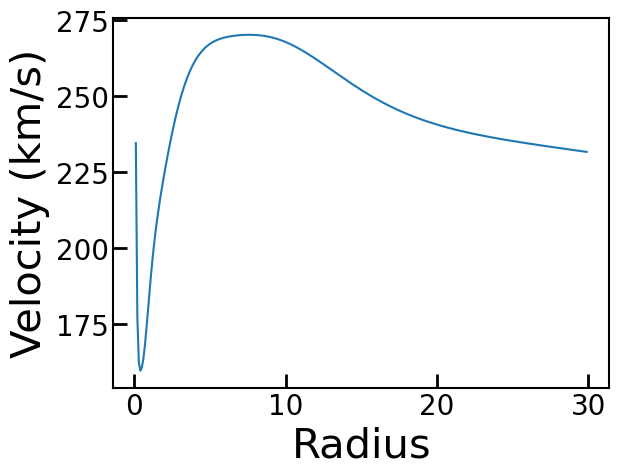

In [24]:
surf=np.array([25551.5, 21118.8, 7436.97, 12016.7, 5862.67, 741.344, 807.669, 212.118])
sigma=np.array([0.226508, 0.661430, 1.30613, 2.17346, 4.76300, 11.3177, 19.2433, 48.5786])
qobs=np.array([0.514866, 0.607566, 0.887495, 0.576108, 0.837162, 0.440516, 0.779643, 0.821153])

mymodel=[velocity_profs.mge_vcirc(surf,sigma,qobs,16.5,guesses=[2,8],minimums=[0.1,7],maximums=[10,10])]

params=np.concatenate([i.guess for i in mymodel])
plt.plot(r,velocity_profs.eval(mymodel,r,params))
plt.xlabel("Radius")
plt.ylabel("Velocity (km/s)")


## Inclination and Position Angle Warps

A similar system can also be used to fit position angle and/or inclination warps. To start, simply import the included warp functions:

In [25]:
from kinms_fitter.warp_funcs import warp_funcs

You have several options for functional forms for the warp profile - currently included are a linear change over some radial range (and flat after this), or a non-parametric fit where the PA/inc can be constrained at a user-specified set of radii, and are linear interpolated between these. You set these to be used by passing a list of required warp functions to `fit.inc_profile` or `fit.pa_profile` respectively. Here are some examples:

In [26]:
fit.inc_profile=[warp_funcs.linear(guesses=[5,60,2],minimums=[-50,0,2],maximums=[50,90,2],fixed=[False,False,True],labels_prefix='inc')]
## fitting a function whole initial guesses have a gradient of 5 degrees/arcsec, an intercept of 60 degrees and that is flat beyond 2" (fixed).


fit.pa_profile=[warp_funcs.tilted_rings(np.array([0,1,2]),guesses=[330,350,360],minimums=[0,0,0],maximums=[400,400,400],labels_prefix='pa')]
## fitting the PA non-parametrically, at 0, 1 and 2", with initial guesses 3320, 350 and 360 degrees.

## Fitting with these velocity/surface brightness profiles

To demonstrate fitting with these surface brightness profiles we will work with ALMA data of a real galaxy, NGC1387, from the ALMA Fornax Cluster Survey ([Zabel et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.483.2251Z/abstract)).  The gas in this galaxy is distributed in a beautiful disc, easily fit with an exponential. We will model the rotation with an arctangent.

First we load in the cube:

In [27]:
import numpy as np
from kinms_fitter import kinms_fitter
from kinms_fitter.sb_profs import sb_profs
from kinms_fitter.velocity_profs import velocity_profs 
cube = "NGC1387.co.image.fits"

fit=kinms_fitter(cube,spatial_trim=[128-32,128+32,128-32,128+32],spectral_trim=[75,102],linefree_chans=[60,70]) # load in your cube, and trim it if needed
fit.pa_guess=245.
fit.inc_guess=30.



Now we can specify the surface brightness profile. 

In [28]:
fit.sb_profile=[sb_profs.expdisk(guesses=[2],minimums=[0.1],maximums=[5])]

The velocity function is a simple arctan:

In [29]:
fit.vel_profile=[velocity_profs.arctan(guesses=np.array([150,0.27]),minimums=np.array([50,0.01]),maximums=[370,10])]

Now we can run the fit, this time with 10,000 steps, starting with a simple minimisation, then running the MCMC to get the errors.  

==============   Welcome to KinMS_fitter!   ==============

        ██╗  ██╗██╗███╗   ██╗███╗   ███╗███████╗
        ██║ ██╔╝██║████╗  ██║████╗ ████║██╔════╝
        █████╔╝ ██║██╔██╗ ██║██╔████╔██║███████╗
        ██╔═██╗ ██║██║╚██╗██║██║╚██╔╝██║╚════██║
        ██║  ██╗██║██║ ╚████║██║ ╚═╝ ██║███████║
        ╚═╝  ╚═╝╚═╝╚═╝  ╚═══╝╚═╝     ╚═╝╚══════╝
        
One model evaluation takes 0.21 seconds


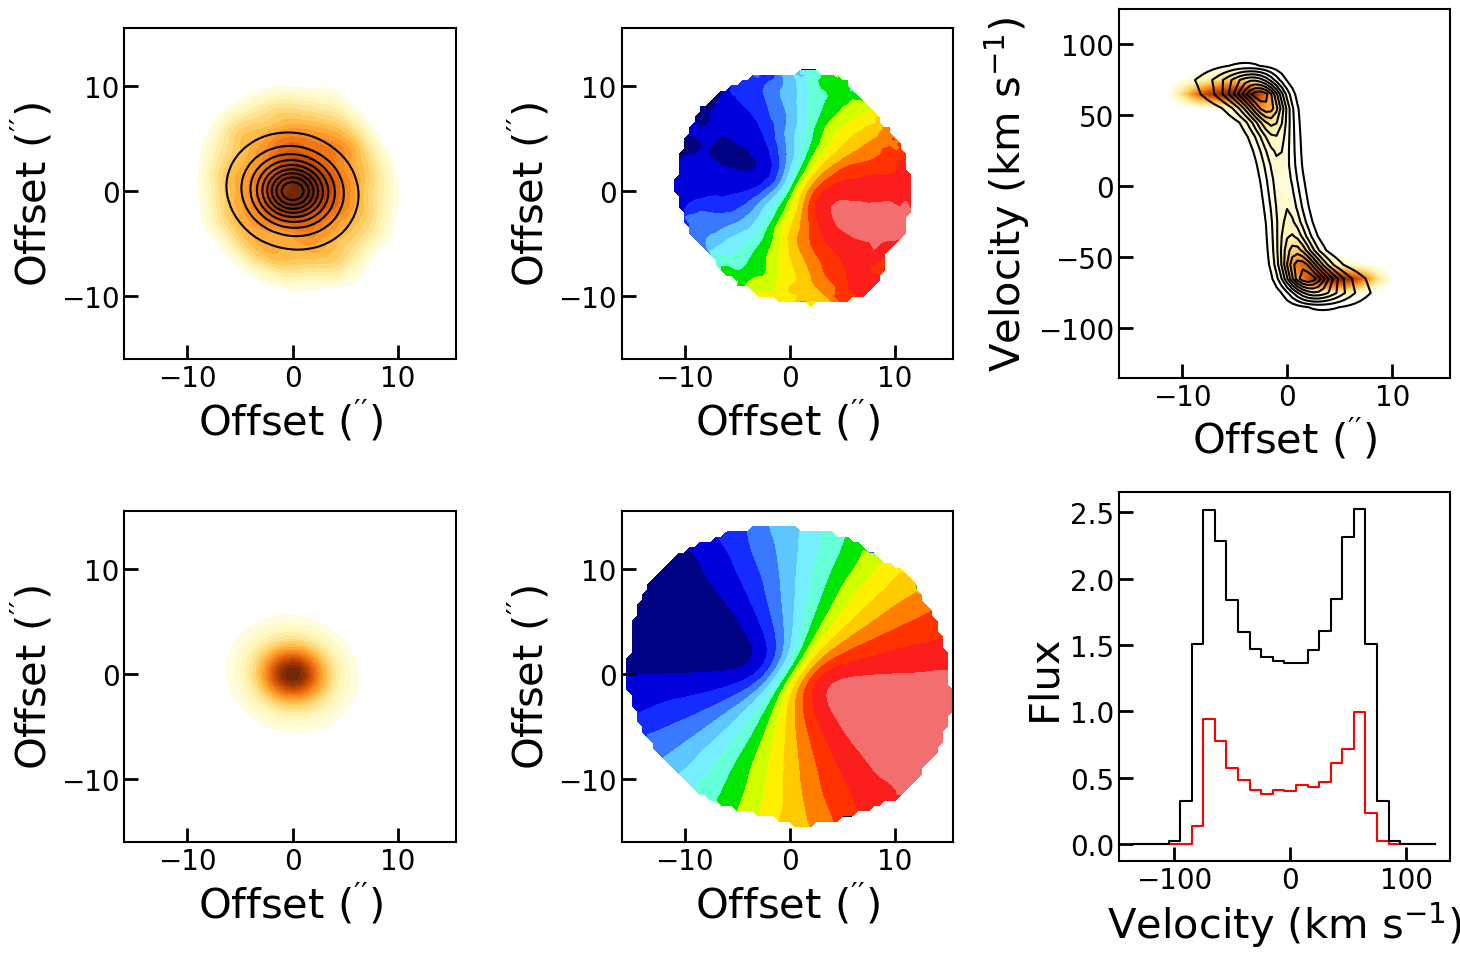

============== Begin simple fitting process ==============
Steps: 0 chi2: 135423.1820660209
Steps: 50 chi2: 134321.67801016438
Steps: 100 chi2: 6134.082035727112
Steps: 150 chi2: 3501.664428008239
Steps: 200 chi2: 3453.9045204295553
Steps: 250 chi2: 2700.963654662312
Steps: 300 chi2: 8960.382889226805
Steps: 350 chi2: 2625.379909327224
Steps: 400 chi2: 2323.90299969547
Steps: 450 chi2: 2226.719990298227
Steps: 500 chi2: 17215.179789771584
Steps: 550 chi2: 2220.9647285079977
Steps: 600 chi2: 2190.4937958452756
Optimization terminated successfully.
         Current function value: 2179.600997
         Iterations: 3
         Function evaluations: 642
Simple fitting process took 132.83 seconds
Best fitting parameters:
   Xc: 0.4335010359451065
   Yc: 0.3903438092162463
   Vsys: 1280.583402420051
   totflux: 89.66313028463195
   veldisp: 3.623048102393781
   PA: 244.24959064268967
   inc: 28.147818493009044
   Rscale_exp: 3.586015414058946
   Vmax: 149.11048635856176
   Rturn: 0.21215668494

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
100%|█████████▉| 29960/29995 [22:27<00:01, 24.90it/s][Parallel(n_jobs=7)]: Done   3 out of   7 | elapsed: 22.5min remaining: 30.0min
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed: 22.5min remaining: 16.9min
[Parallel(n_jobs=7)]: Done   5 out of   7 | elapsed: 22.5min remaining:  9.0min
100%|█████████▉| 29988/29995 [22:28<00:00, 22.24it/s]
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed: 22.5min finished


Final best fit values and 1sigma errors:
  Xc: 0.4509976544648828 + 0.030683558017844947 - 0.026774000222646754
  Yc: 0.39433099085400686 + 0.020899801421838338 - 0.025714252145427163
  Vsys: 1280.6706923775932 + 0.13711903233615885 - 0.12259634361066674
  totflux: 92.29955809277376 ± 0.9615712101129645
  veldisp: 4.06781845489744 ± 0.12862004201339716
  PA: 244.24928847609246 + 0.21128183489639696 - 0.24065457868968565
  inc: 27.293582397194697 ± 0.4588421733136947
  Rscale_exp: 3.699589092988224 ± 0.03498965523259945
  Vmax: 151.08615995176638 + 2.685200516790303 - 2.2438032554588005
  Rturn: 0.12083151822142565 + 0.02054859489136257 - 0.014474291590163377
MCMC fitting process took 1800.19 seconds


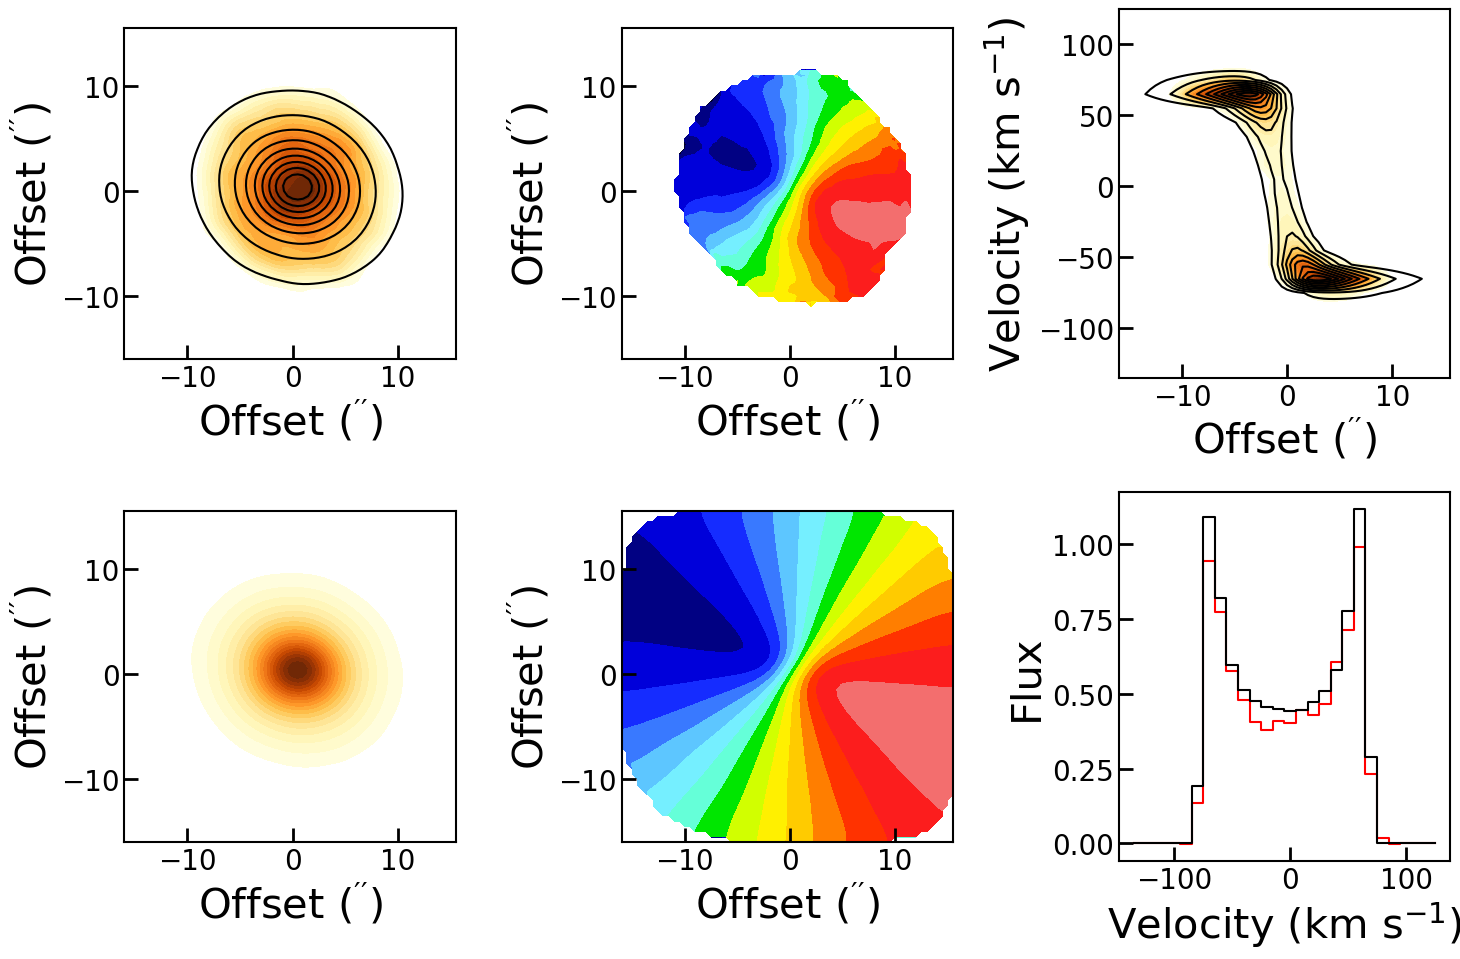

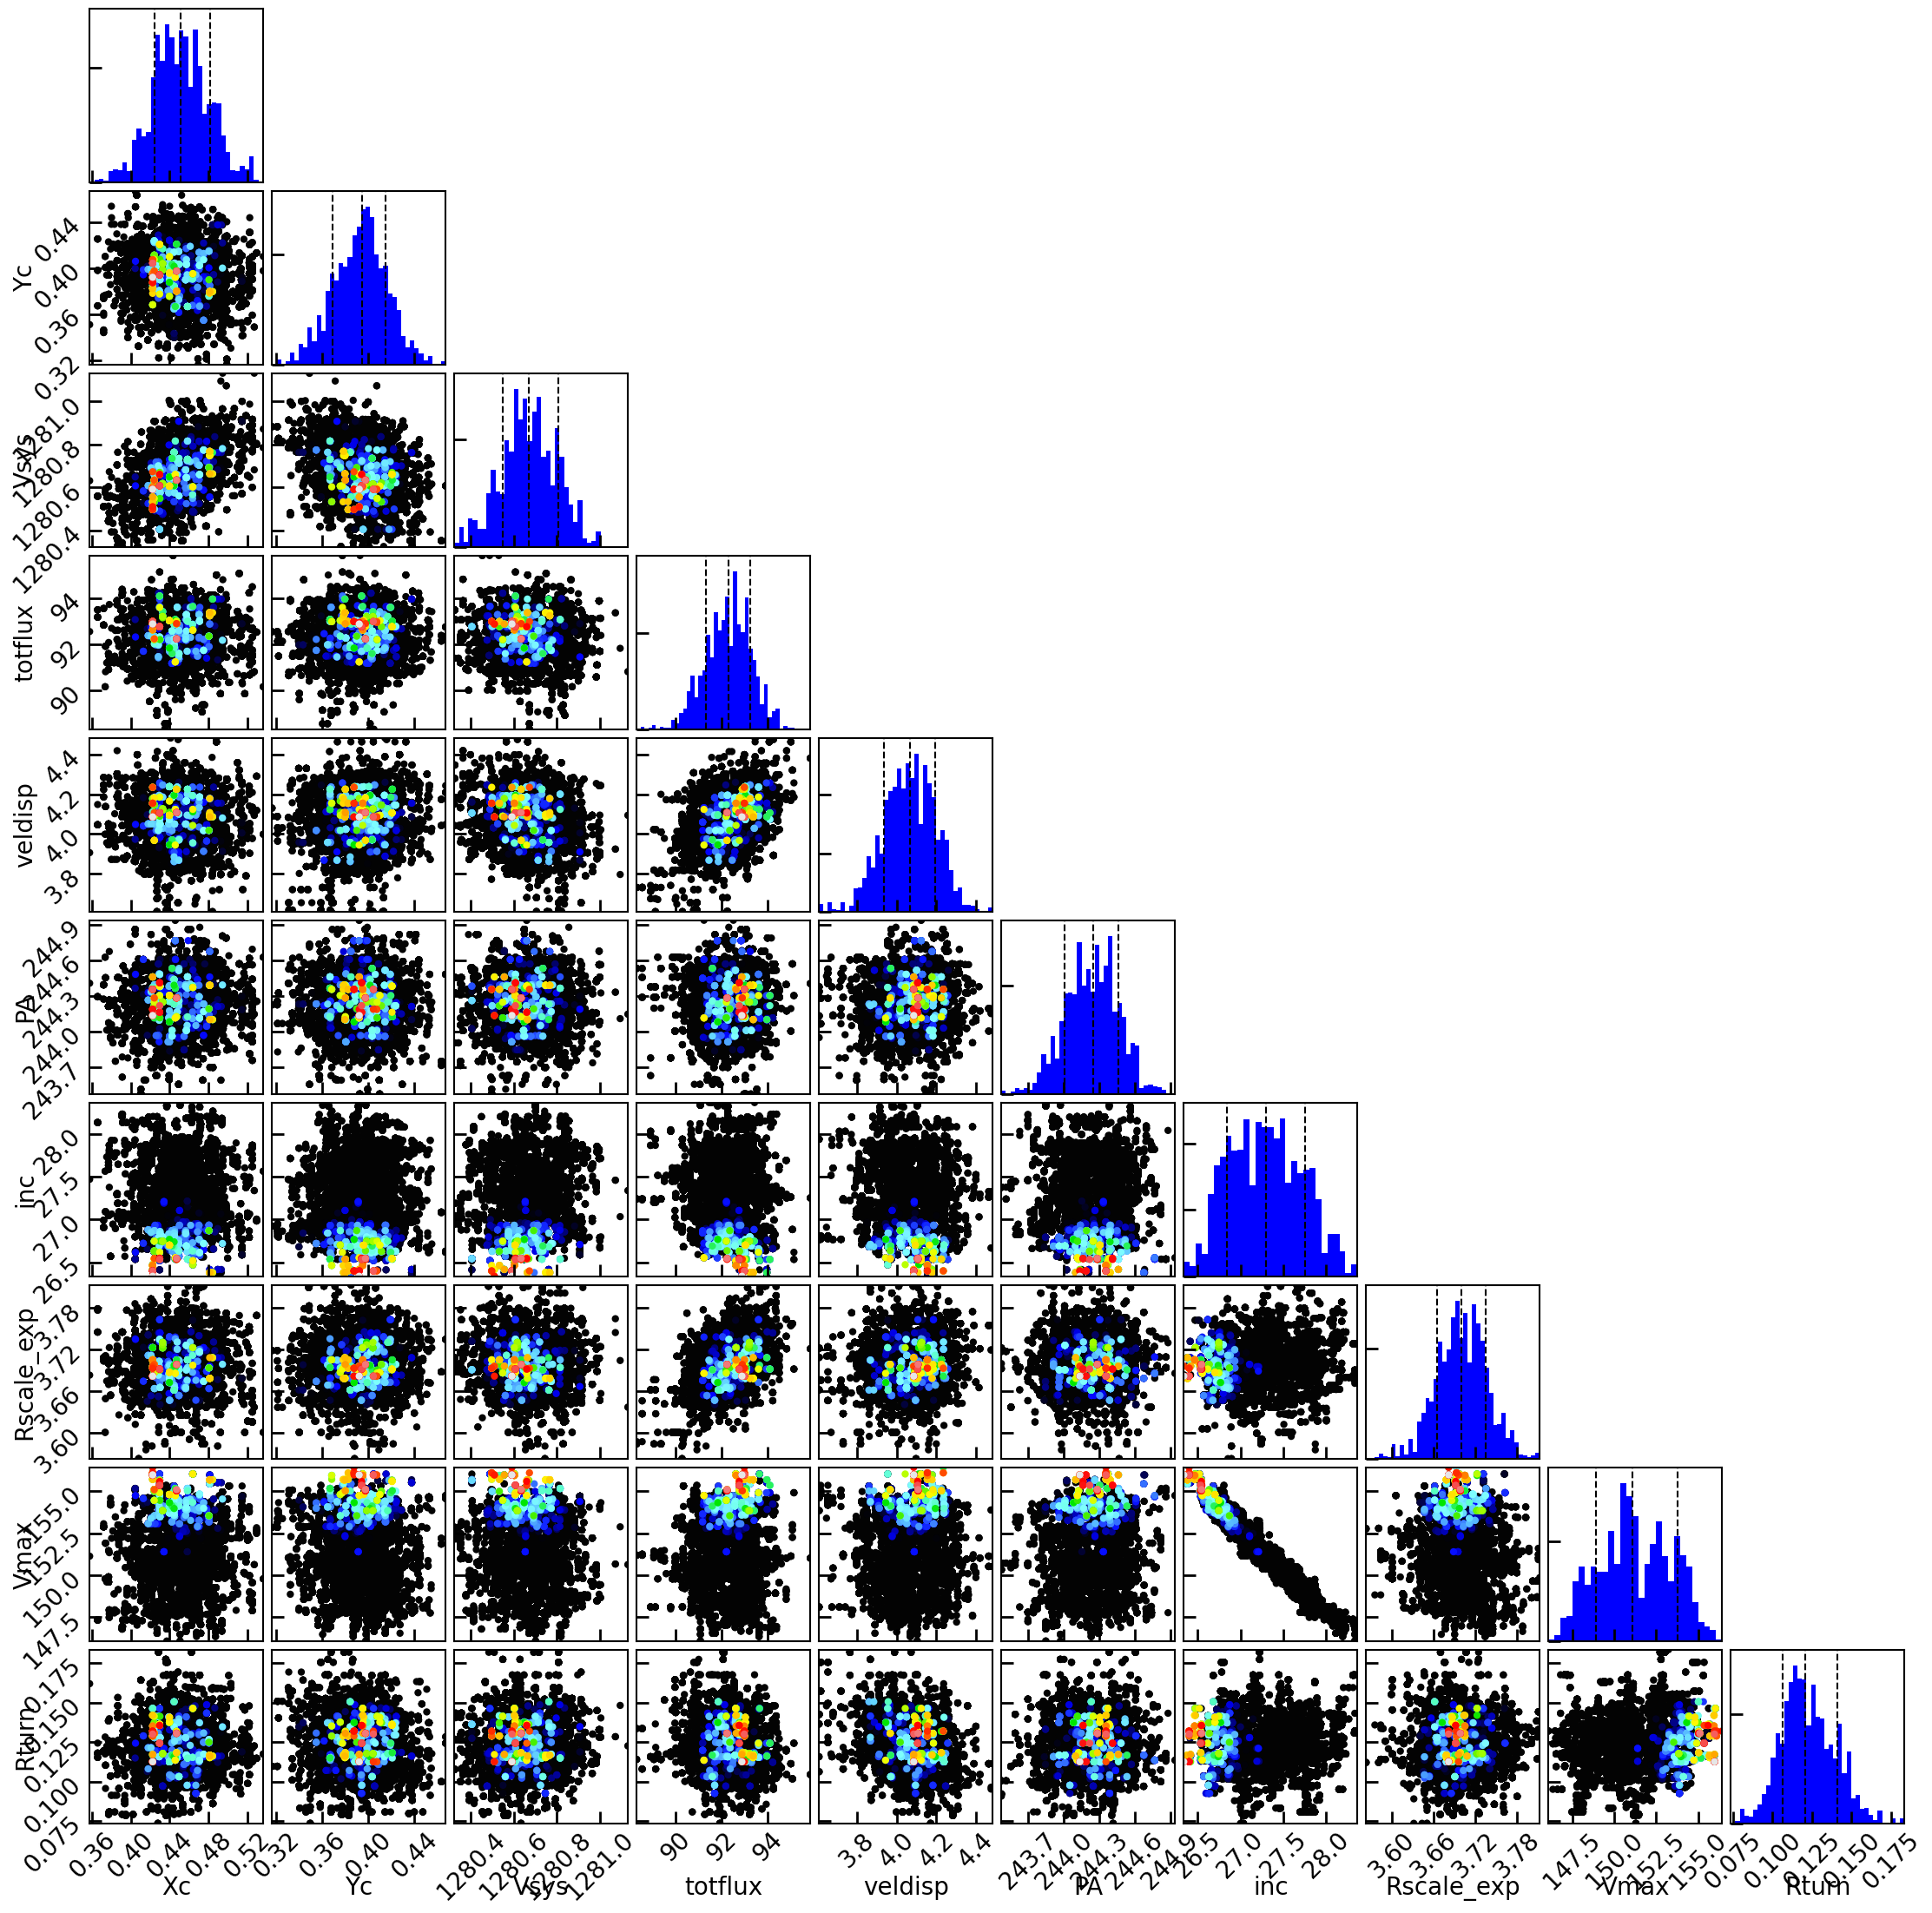

In [30]:
fit.niters=30000
bestvals, besterrs, outputvalue, outputll,_ = fit.run(method='both')

In [31]:
print(Table([fit.labels,bestvals,besterrs],names=('Quantity', 'Bestfit','1-sigma error')))

 Quantity        Bestfit          1-sigma error    
---------- ------------------- --------------------
        Xc  54.237646106143366 0.028792874573871086
        Yc -35.506571463515925 0.023421958490386387
      Vsys  1280.6706923775932  0.12877173355729474
   totflux   92.29955809277376    0.993441701130188
   veldisp    4.06781845489744  0.13209459182992722
        PA  244.24928847609246  0.22472193430290996
       inc  27.293582397194697  0.41936398562243393
Rscale_exp   3.699589092988224 0.036703978189651626
      Vmax  151.08615995176638    2.141236545447456
     Rturn 0.12083151822142565 0.017056747159701263


This final model is pretty darn good! Hopefully this gives you a good idea of how to use the flexible rotation curve/surface brightness profile functions!
